In [1]:
!pip install transformers datasets scikit-learn seaborn -q

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import psutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set device (Gunakan GPU jika tersedia di Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dan unzip dataset (ganti 'rizkyyk/dataset-food-classification' jika beda)
!kaggle datasets download -d rizkyyk/dataset-food-classification -p /content/data --unzip
print("Dataset downloaded and unzipped.")

Dataset URL: https://www.kaggle.com/datasets/rizkyyk/dataset-food-classification
License(s): MIT
 99% 1.08G/1.09G [00:17<00:00, 246MB/s]
100% 1.09G/1.09G [00:17<00:00, 67.1MB/s]
Dataset downloaded and unzipped.


In [3]:
DATASET_ROOT = "/content/data/dataset_gambar"

# Jika dataset-nya unzip ke folder 'Dataset' (default kaggle)
# DATASET_ROOT = "/content/data/Dataset"
# Pastikan DATASET_ROOT Anda benar

TRAIN_PATH = os.path.join(DATASET_ROOT, "train")
VAL_PATH = os.path.join(DATASET_ROOT, "valid")
TEST_PATH = os.path.join(DATASET_ROOT, "test")

SAVE_PATH = "/content/drive/My Drive/ViT_Project"
os.makedirs(SAVE_PATH, exist_ok=True)
BEST_MODEL_PATH = os.path.join(SAVE_PATH, "deit_murni_best.pth")

# --- 2b. Definisikan Model ID dan Processor ---
MODEL_ID = "facebook/deit-base-distilled-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(MODEL_ID)

image_mean = image_processor.image_mean
image_std = image_processor.image_std
size = 224 # Paksa jadi 224

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(size + 32), # 256
    transforms.CenterCrop(size),  # 224
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std),
])

# Terapkan transform ke folder yang benar
train_dataset = ImageFolder(TRAIN_PATH, transform=train_transforms)
val_dataset = ImageFolder(VAL_PATH, transform=val_test_transforms)
test_dataset = ImageFolder(TEST_PATH, transform=val_test_transforms)


In [5]:
# Dapatkan nama kelas dari train_dataset
class_names = train_dataset.classes
num_labels = len(class_names)
print(f"Kelas ditemukan ({num_labels}): {class_names}")
print(f"Ukuran Data: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")

# --- 2e. Buat DataLoaders ---
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Kelas ditemukan (13): ['Ayam Goreng', 'Burger', 'French Fries', 'Gado-Gado', 'Ikan Goreng', 'Mie Goreng', 'Nasi Goreng', 'Nasi Padang', 'Pizza', 'Rawon', 'Rendang', 'Sate', 'Soto']
Ukuran Data: 5193 train, 650 val, 648 test


In [6]:
print(f"Memuat model pretrained: {MODEL_ID}")
model = AutoModelForImageClassification.from_pretrained(
    MODEL_ID,
    num_labels=num_labels,
    ignore_mismatched_sizes=True # Ganti head klasifikasi
).to(device)

for param in model.parameters():
    param.requires_grad = True
print("Semua parameter model telah di-unfreeze (requires_grad=True).")

Memuat model pretrained: facebook/deit-base-distilled-patch16-224


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([13]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Semua parameter model telah di-unfreeze (requires_grad=True).


In [7]:
print(model)

DeiTForImageClassificationWithTeacher(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)

In [8]:
NUM_EPOCHS = 5
LEARNING_RATE = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,
    eta_min=1e-6  # Nilai LR minimum yang akan dicapai
)
# Variabel untuk menyimpan model terbaik
best_val_accuracy = 0.0

# History untuk plotting (Metrik B)
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

In [9]:
print("Memulai pelatihan...")

# --- 3c. Loop Pelatihan ---
for epoch in range(NUM_EPOCHS):

    # --- Training ---
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_pbar.set_postfix({'loss': running_train_loss / (train_pbar.n + 1)})

    train_loss = running_train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_pbar.set_postfix({'val_loss': running_val_loss / (val_pbar.n + 1)})

    val_loss = running_val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step()
    print(f"Current LR: {scheduler.get_last_lr()[0]}")
    # Simpan model terbaik
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"Model terbaik disimpan ke {BEST_MODEL_PATH} (Val Acc: {val_acc:.2f}%)")

print("Pelatihan selesai.")

Memulai pelatihan...


Epoch 1/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.5027, Train Acc: 86.66% - Val Loss: 0.2223, Val Acc: 93.23%
Current LR: 4.532091636218621e-05
Model terbaik disimpan ke /content/drive/My Drive/ViT_Project/deit_murni_best.pth (Val Acc: 93.23%)


Epoch 2/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.1057, Train Acc: 97.03% - Val Loss: 0.1479, Val Acc: 95.38%
Current LR: 3.307091636218621e-05
Model terbaik disimpan ke /content/drive/My Drive/ViT_Project/deit_murni_best.pth (Val Acc: 95.38%)


Epoch 3/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.0425, Train Acc: 99.06% - Val Loss: 0.1311, Val Acc: 95.54%
Current LR: 1.792908363781379e-05
Model terbaik disimpan ke /content/drive/My Drive/ViT_Project/deit_murni_best.pth (Val Acc: 95.54%)


Epoch 4/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef133dece00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef133dece00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.0232, Train Acc: 99.44% - Val Loss: 0.1346, Val Acc: 95.85%
Current LR: 5.67908363781379e-06
Model terbaik disimpan ke /content/drive/My Drive/ViT_Project/deit_murni_best.pth (Val Acc: 95.85%)


Epoch 5/5 [Train]:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.0125, Train Acc: 99.75% - Val Loss: 0.1215, Val Acc: 95.85%
Current LR: 1e-06
Pelatihan selesai.


In [10]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.to(device)
model.eval()

DeiTForImageClassificationWithTeacher(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)

In [12]:
print("--- Spesifikasi Hardware ---")

# Cek GPU
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_vram = torch.cuda.get_device_properties(0).total_memory / (1024**3) # GB
    print(f"Device     : GPU ({gpu_name})")
    print(f"VRAM       : {gpu_vram:.2f} GB")
    print(f"CUDA Cap   : {torch.cuda.get_device_capability(0)}")
else:
    print("Device     : CPU (GPU tidak terdeteksi)")

print(f"CPU Cores  : {os.cpu_count()} Cores")

# Cek RAM System
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"System RAM : {ram_gb:.2f} GB")

print("\n--- Jumlah Parameter ---")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

# Ukuran model dalam MB
torch.save(model.state_dict(), "temp_model_size.pth")
model_size_mb = os.path.getsize("temp_model_size.pth") / (1024 * 1024)
os.remove("temp_model_size.pth")

print(f"Total parameter: {total_params:,}")
print(f"Parameter dapat dilatih: {trainable_params:,}")
print(f"Parameter tidak dapat dilatih: {non_trainable_params:,}")
print(f"Ukuran model: {model_size_mb:.2f} MB")

--- Spesifikasi Hardware ---
Device     : GPU (Tesla T4)
VRAM       : 14.74 GB
CUDA Cap   : (7, 5)
CPU Cores  : 2 Cores
System RAM : 12.67 GB

--- Jumlah Parameter ---
Total parameter: 85,820,186
Parameter dapat dilatih: 85,820,186
Parameter tidak dapat dilatih: 0
Ukuran model: 327.46 MB


In [13]:
print("\n--- B. Metrik Performa (Test Set) ---")
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Mengevaluasi Test Set"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


--- B. Metrik Performa (Test Set) ---


Mengevaluasi Test Set:   0%|          | 0/21 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef133dece00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef133dece00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

In [14]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"Akurasi Keseluruhan (Test Set): {accuracy * 100:.2f}%")

Akurasi Keseluruhan (Test Set): 96.91%


In [15]:
print("\nLaporan Klasifikasi (Per Kelas & Rata-rata):")
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)


Laporan Klasifikasi (Per Kelas & Rata-rata):
              precision    recall  f1-score   support

 Ayam Goreng     0.9375    0.9000    0.9184        50
      Burger     0.9804    1.0000    0.9901        50
French Fries     1.0000    1.0000    1.0000        50
   Gado-Gado     0.9423    0.9800    0.9608        50
 Ikan Goreng     0.9615    1.0000    0.9804        50
  Mie Goreng     0.9796    0.9600    0.9697        50
 Nasi Goreng     0.9796    0.9600    0.9697        50
 Nasi Padang     0.8750    0.9800    0.9245        50
       Pizza     1.0000    1.0000    1.0000        50
       Rawon     1.0000    0.9792    0.9895        48
     Rendang     0.9592    0.9400    0.9495        50
        Sate     1.0000    0.9200    0.9583        50
        Soto     1.0000    0.9800    0.9899        50

    accuracy                         0.9691       648
   macro avg     0.9704    0.9692    0.9693       648
weighted avg     0.9703    0.9691    0.9692       648




Confusion Matrix (Visualisasi):


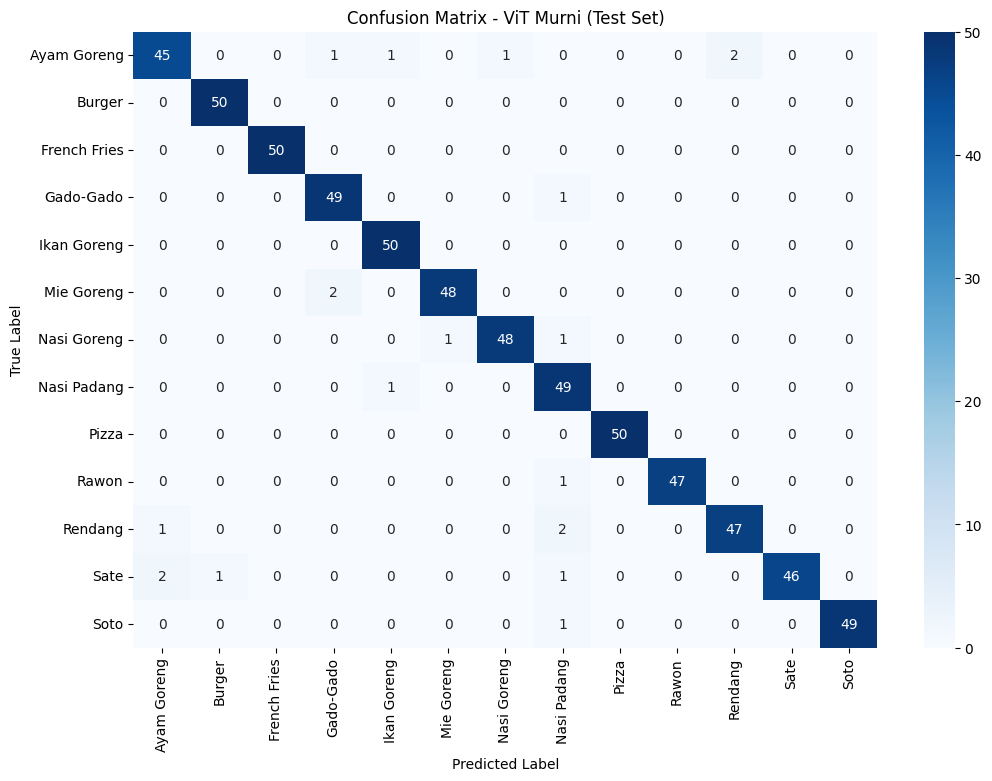

In [16]:
print("\nConfusion Matrix (Visualisasi):")
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - ViT Murni (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Kurva Pembelajaran (Training & Validation):


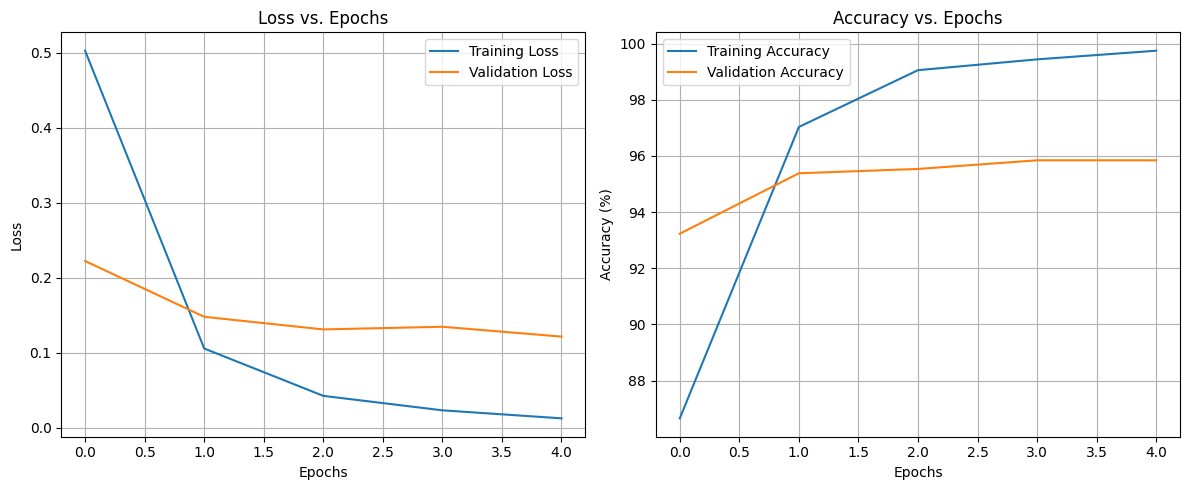

In [17]:
print("\nKurva Pembelajaran (Training & Validation):")
plt.figure(figsize=(12, 5)) # Ukuran 12x5 biasanya lebih baik

# Plot Loss
plt.subplot(1, 2, 1) # Plot 1 (kiri)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) # Tambahkan grid agar mudah dibaca

# Plot Accuracy
plt.subplot(1, 2, 2) # Plot 2 (kanan)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True) # Tambahkan grid

plt.tight_layout() # Agar plot tidak tumpang tindih
plt.show()

In [18]:
print("\n--- C. Waktu Inferensi ---")

# --- Waktu per Gambar (ms) ---
# Buat loader baru dengan batch_size=1
test_loader_bs1 = DataLoader(test_dataset, batch_size=1, shuffle=False)
iterator_bs1 = iter(test_loader_bs1)

# Persiapan CUDA Events
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
timings_ms = []

# Warm-up (Sesuai Rancangan)
print("Melakukan warm-up GPU...")
for _ in range(20):
    _ = model(torch.randn(1, 3, size, size).to(device))

print("Mengukur waktu inferensi per gambar (min 100 gambar)...")
with torch.no_grad():
    for i in range(100):
        try:
            inputs, _ = next(iterator_bs1)
            inputs = inputs.to(device)

            starter.record()
            _ = model(inputs)
            ender.record()

            torch.cuda.synchronize() # Sinkronisasi CPU-GPU
            curr_time_ms = starter.elapsed_time(ender)
            timings_ms.append(curr_time_ms)
        except StopIteration:
            break # Habis data

avg_time_ms = np.mean(timings_ms)
std_dev_ms = np.std(timings_ms)
print(f"Waktu inferensi rata-rata per gambar: {avg_time_ms:.2f} ms (± {std_dev_ms:.2f} ms)")


--- C. Waktu Inferensi ---
Melakukan warm-up GPU...
Mengukur waktu inferensi per gambar (min 100 gambar)...
Waktu inferensi rata-rata per gambar: 11.29 ms (± 0.87 ms)


In [19]:
print("Mengukur throughput (gambar/detik) pada seluruh test set...")
start_total_time = time.time()
with torch.no_grad():
    for inputs, labels in test_loader: # Menggunakan test_loader batch_size 32
        inputs = inputs.to(device)
        _ = model(inputs)
        torch.cuda.synchronize() # Pastikan batch selesai diproses

end_total_time = time.time()
total_inference_time_sec = end_total_time - start_total_time
total_test_images = len(test_dataset)
throughput_fps = total_test_images / total_inference_time_sec

print(f"Waktu inferensi total (Test Set): {total_inference_time_sec:.2f} detik")
print(f"Throughput: {throughput_fps:.2f} gambar/detik")

Mengukur throughput (gambar/detik) pada seluruh test set...
Waktu inferensi total (Test Set): 15.36 detik
Throughput: 42.19 gambar/detik
